# Exercise 4: Hamiltonian replica exchange molecular dynamics (HREMD)

In this exercise, the goal is to run a Hamiltonian replica exchange molecule dynamics (HREMD) simulation for a 4-site system and calculate its solvation free energy. This 4-site system, as shown in the figure below, is composed of 4 linearly-connected interaction sites. It has two metastable states separated by a torsional free energy barrier coupled with the alchemical variable. Specifically,
- In an unbiased simulation in the first alchemical intermediate state, the system can barely sample both torsional metastable states.
- In an unbiased simulation in the last alchemical intermediate state, the system can sample both torsional metastable states much more easily. 

Here, we will use 8 alchemical intermediate states (hence 8 replicas in the HREMD simulation) to gradually turn off electrostatic and then van der Waals interactions. 

While the alchemical pathway (the $\lambda$ value for each state) should be indpedendent of the free energy, the choice of pathway will greatly affect the sampling efficiency. Here are a few rules of thumb: 
- Maximize the similiarity between neighboring states.
- Turn off charges before turning off the van der Waals interactions, so there won't be infinite attractive potential.
- Use the soft-core potential when turning off the van der Waals interactions to avoid the singularity problem.

## 1. Preparation of the input files

In [ ]:
%%bash
# Here we remove the output of the exercise if there is any.
dirs=(state_* dhdl_files theta_files)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

The major differences between an `mdp` file for REMD simulations and one for standard MD simulation lie in the options for free energy calculations and the specification of the alchemical variables. 

In [ ]:
%%bash
tail -n 18 ../Inputs/4-site/HREMD.mdp

In [ ]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

n=8      # number of alchemical intermediate states
for i in {0..7}
do
    mkdir state_${i} && cd state_${i}
    cp ../../Inputs/4-site/sys.gro .
    cp ../../Inputs/4-site/sys.top .
    cp ../../Inputs/4-site/HREMD.mdp .
    sed -i -e "s/init-lambda-state        = 0/init-lambda-state        = ${i}/g" HREMD.mdp
    mpirun -np 1 gmx_mpi grompp -f HREMD.mdp -c sys.gro -p sys.top -o HREMD.tpr && cd ../
done

## 2. Running HREMD simulations

In [ ]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
mpirun -np 8 gmx_mpi mdrun -deffnm HREMD -dhdl dhdl.xvg -replex 100 -nex 512 -multidir state_0 state_1 state_2 state_3 state_4 state_5 state_6 state_7 -noappend -ntomp 1

## 3. Data analysis

After the simulation is finished, an `dhdl*xvg` file should appear in each folder. These `*dhdl*xvg` files contain the derivative of the total energy (or potential energy) with respect to the $\lambda$ values, as a function of time. They are important for performing free energy calculations. 

In [ ]:
%%bash
ls state_0/

In [ ]:
%%bash
mkdir dhdl_files && cd dhdl_files
for i in {0..7};
do
    mkdir state_${i}
    cp ../state_${i}/dhdl*xvg state_${i}/.
done

In [1]:
import os
import re
import glob
import natsort
import pymbar
import alchemlyb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from pymbar.timeseries import detect_equilibration, subsample_correlated_data
from alchemlyb.preprocessing import subsampling
from alchemlyb.estimators import MBAR
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.visualisation import plot_mbar_overlap_matrix 

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


The protocol we adopt here for alchemical free energy calculations is composed of the following steps:
- **Step 1**: Collect all `dhdl*xvg` files from different folders/replicas.
- **Step 2**: For each replica, subsample the timeseries of $dH/d\lambda$ to get the uncorrelated samples. 
- **Step 3**: Concatenate the preprocessed data from all replicas. 
- **Step 4**: Feed the concatenated data to MBAR to calculate the free energy difference. 

In [ ]:
N = 8      # number of replicas
T = 300    # simulation temperature
dhdl_dir = 'dhdl_files'

folders = [f'{dhdl_dir}/state_{i}' for i in range(N)]
u_nk_data = []
for i in range(N):
    files = glob.glob(os.path.join(folders[i], '*dhdl*xvg*'))
    files = natsort.natsorted(files, reverse=False)
    print(f'  Collecting data for the following files: {", ".join(files)}')
    u_nk = alchemlyb.concat([extract_u_nk(xvg, T=T) for xvg in files])
    u_nk_series = subsampling.u_nk2series(u_nk)
    u_nk, u_nk_series = subsampling._prepare_input(u_nk, u_nk_series, drop_duplicates=True, sort=True)
    u_nk = subsampling.slicing(u_nk, step=1)
    u_nk_series = subsampling.slicing(u_nk_series, step=1)
    
    t, statinef, Neff_max = detect_equilibration(u_nk_series.values)
    u_nk_series_equil, u_nk_equil = u_nk_series[t:], u_nk[t:]
    indices = subsample_correlated_data(u_nk_series_equil, g=statinef)
    preprocessed_u_nk = u_nk_equil.iloc[indices]
    u_nk_data.append(preprocessed_u_nk)

u_nk_data = alchemlyb.concat(u_nk_data)
print('  Fitting MBAR on u_nk ...')
try:
    mbar_stop = False
    mbar = MBAR().fit(u_nk_data)
except pymbar.utils.ParameterError():
    mbar_stop = True
    print("\sum_n W_nk is not equal to 1, probably due to insufficient overlap between states.")
    print("Stop using MBAR ...")

if mbar_stop is False:
    print(f"  MBAR: {mbar.delta_f_.iloc[0, -1]:.4f} +/- {mbar.d_delta_f_.iloc[0, -1]:.4f} kT")    

From the MBAR estimator fitted on the dhdl data, we can also compute the overlap matrix, which is useful for tweaking the alchemical path if we want to improve the sampling. 

In [ ]:
plot_mbar_overlap_matrix(mbar.overlap_matrix)

The `log` files document how what replicas were exchanged along the way, which allows us to recover the continuous trajecotry for each configuration (jumping between different alchemical sates). 

In [ ]:
def get_HREX_trajs(log):
    """
    Parses the log file to get the state-space trajectory for each starting 
    configuraiton in a HREX simulation. As indicated in the source code "mdrun/replicaexchange.cpp",
    the "Order After Exchange" is the state label corresponding to the configuration
    that started in state listed in order, i.e. 3 0 1 2 means that the 
      - Configuration starting in state 3 (config 3) is now in state 0
      - Configuration starting in state 0 (config 0) is now in state 1
      - Configuration starting in state 1 (config 1) is now in state 2
      - Configuration starting in state 2 (config 2) is now in state 3
    Here, what we want to produce is a list of state-space trajectories with trajs[i] being
    the continuous trajectory of config i. 

    Parameters
    ----------
    log : str
        The filename of the log file to be parsed.
    
    Returns
    -------
    trajs : list
        A list of state-space trajectories.
    dt_traj : float
        Exchange period in ps.
    """
    f = open(log, 'r')
    lines = f.readlines()
    f.close()

    pattern = re.compile('Repl  There are \d+ replicas:')
    
    # First find relevant parameters
    for l in lines:
        if ' dt ' in l:
            dt = float(l.split('=')[-1]) # ps

        if 'gmx_mpi mdrun' in l:
            replex = int(l.split('-replex')[1].split()[0])

        if pattern.match(l):
            n_replicas = int(l.split('are')[-1].split('replicas')[0])
            break # this should be found last so we can break here

    trajs = [list(range(n_replicas))]  # always start from [0, 1, 2, ...]
    dt_traj = dt * replex   # exhcnage period in ps

    for l in lines:
        if 'Order After Exchange' in l:
            config_idx = [int(i) for i in l.split(':')[1].split()]
            state_idx = [config_idx.index(i) for i in range(n_replicas)]
            trajs.append(state_idx)
    trajs = np.array(trajs).T

    return trajs, dt_traj

In [ ]:
state_trajs, dt_traj = get_HREX_trajs('state_0/HREMD.part0001.log')
cmap = plt.cm.ocean
colors = [cmap(i) for i in np.arange(N) / N]

plt.figure()
for i in range(len(trajs)):
    plt.plot(np.arange(len(state_trajs[i])) * dt_traj, trajs[i], label=f'config {i}', alpha=0.5, color=colors[i])
    plt.xlabel('Time (ps)')
    plt.ylabel('State index')
    plt.legend()
plt.grid()

In this case, since the torsional barrier is coupled with the alchemical barrier, the sampling in the torsional space should also be accelerated when each configuration is able to sampel all alchemical states.

In [ ]:
%%bash
echo 'theta: TORSION ATOMS=1,2,3,4
PRINT ARG=theta FILE=theta.dat STRIDE=1
' > plumed_theta.dat

In [ ]:
import subprocess
# define the PLUMED binary
plumed_bin="singularity exec /ocean/projects/see220002p/shared/icomse_cpu.sif plumed"

# Define a function that helps us run PLUMED commands
def run_plumed_cmd(cmd,verbose=False):
    cmd_str="{} ".format(plumed_bin)+cmd
    print("PLUMED command: {}".format(cmd_str))
    if verbose:
        subprocess.run(cmd_str.split())
    else:
        subprocess.run(cmd_str.split(),stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [ ]:
os.mkdir('theta_files')
for i in range(N):
    run_plumed_cmd(f'driver --mf_xtc state_{i}/HREMD.part0001.xtc --plumed plumed_theta.dat', verbose=True)
    os.system(f'mv theta.dat theta_files/theta_{i}.dat')

In [ ]:
theta = []
for i in range(8):
    theta.append(list(np.transpose(np.loadtxt(f'theta_files/theta_{i}.dat', comments=['#!']))[1]))
theta = np.array(theta)

theta_trajs = np.zeros(state_trajs.shape)
for i in range(theta_trajs.shape[0]):
    for j in range(theta_trajs.shape[1]):
        # The state of configuration i at time frame j
        state = state_trajs[i][j]
        # theta[i][j] is the dihedral of whatever configuration in state i at time frame j
        theta_trajs[i][j] = theta[state][j]

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.scatter(np.arange(state_trajs.shape[1]) * dt_traj, theta_trajs[i], s=0.5)
    plt.ylim([-np.pi, np.pi])
    plt.grid()
    plt.text(0, 2.2, f'Configuration {i}', weight='bold', fontsize=12)
    plt.ylabel('Dihedral angle (rad)')
    if i >=6:
        plt.xlabel('Time (ps)')

Here are the sampled torsional angles in each state (with the trajectory composed of different configurations). 

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(8):
    theta_data = np.transpose(np.loadtxt(f'theta_files/theta_{i}.dat', comments=['#!']))
    plt.subplot(4, 2, i+1)
    plt.scatter(theta_data[0], theta_data[1], s=0.5)
    plt.ylim([-np.pi, np.pi])
    plt.grid()
    plt.text(100, 2.2, f'State {i}', weight='bold', fontsize=12)
    plt.ylabel('Dihedral angle (rad)')
    if i >=6:
        plt.xlabel('Time (ps)')

## 4. References
- The paper that proposed the replica-exchange framework: [Sugita, Yuji, and Yuko Okamoto. "Replica-exchange molecular dynamics method for protein folding." Chemical physics letters 314.1-2 (1999): 141-151.](https://doi.org/10.1016/S0009-2614(99)01123-9)
- The paper that proposed Hamiltonian replica exchange: [Sugita, Yuji, Akio Kitao, and Yuko Okamoto. "Multidimensional replica-exchange method for free-energy calculations." The Journal of chemical physics 113.15 (2000): 6042-6051.](https://doi.org/10.1063/1.1308516)
- An excellent review on alchemical free energy methods: [Mey, Antonia SJS, et al. "Best practices for alchemical free energy calculations." arXiv preprint arXiv:2008.03067 (2020).](https://doi.org/10.33011/livecoms.2.1.18378)

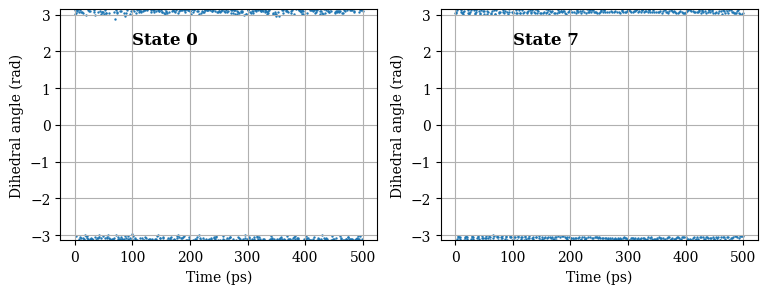

In [2]:
plt.figure(figsize=(9, 3))
idx = [0, 7]
for i in range(len(idx)):
    theta_data = np.transpose(np.loadtxt(f'standard_MD/state_{idx[i]}/theta.dat', comments=['#!']))
    plt.subplot(1, 2, i + 1)
    plt.scatter(theta_data[0], theta_data[1], s=0.5)
    plt.ylim([-np.pi, np.pi])
    plt.grid()
    plt.text(100, 2.2, f'State {idx[i]}', weight='bold', fontsize=12)
    plt.xlabel('Time (ps)')
    plt.ylabel('Dihedral angle (rad)')

In [ ]:
data_1 = np.transpose(np.loadtxt('test/state_0/theta.dat'))

plt.figure()
plt.subplot(2, 1, 1)
plt.scatter(data_1[0], data_1[1], s=0.5)
plt.grid()